# Google Play Store Apps EDA & Predictive Modeling Project

## Introduction

This project analyzes the Google Play Store Apps dataset to uncover key insights about app categories, ratings, user engagement, and review sentiment. Through a combination of exploratory data analysis (EDA), feature engineering, sentiment mining, and predictive modeling, the goal is to understand which factors drive app success, user satisfaction, and install growth.

We explore:
- The distribution of app ratings and installs across categories
- Patterns and problem areas among low-rated apps
- Relationships between app features (price, size, content rating, update frequency) and user feedback
- How review sentiment relates to app ratings and popularity
- The impact of update activity on app ratings over time
- Building predictive models to forecast app ratings based on multiple features

The insights and models developed here are intended to help app developers, marketers, and business analysts identify what makes top-performing apps stand out and how user experience can be improved across the Play Store ecosystem.


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
import shap
import streamlit as st
import joblib

## Step 1: Loading and Previewing the Dataset

We begin by loading both the Google Play Store apps and user review datasets using Pandas.  
Previewing the first few rows will help us understand the structure of the data and guide our cleaning and analysis steps.

In [106]:
df_apps = pd.read_csv('googleplaystore.csv')
df_reviews = pd.read_csv('googleplaystore_user_reviews.csv')

"First, load both datasets into Pandas DataFrames and preview the initial rows to understand the columns and structure. This helps identify key variables for analysis."

In [107]:
#preview the data
print(df_apps.head())
print(df_reviews.head())

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend 

In [108]:
#Basic info and descriptive summary
df_apps.info()
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
--

In [109]:
#get a quick statistical summary
print(df_apps.describe())
print(df_reviews.describe())

            Rating
count  9367.000000
mean      4.193338
std       0.537431
min       1.000000
25%       4.000000
50%       4.300000
75%       4.500000
max      19.000000
       Sentiment_Polarity  Sentiment_Subjectivity
count        37432.000000            37432.000000
mean             0.182146                0.492704
std              0.351301                0.259949
min             -1.000000                0.000000
25%              0.000000                0.357143
50%              0.150000                0.514286
75%              0.400000                0.650000
max              1.000000                1.000000


"Display dataset info and summary statistics to assess column types, missing values, and distribution insights at a glance. This will guide later cleaning and analysis decisions."

Quick Interpretation of .info() Results
Google Play Store Apps CSV
Rows: 10,841 apps

Columns: 13 features (App, Category, Rating, Reviews, Size, Installs, etc.)

Issues to Note:

Missing Values:

Rating (~1,474 missing), Type (1), Content Rating (1), Current Ver (8), Android Ver (3)

Data Types:

Reviews, Size, Installs, Price are objects—not numbers (means you’ll need to fix these!)

Next Steps:

Clean missing values

Convert relevant columns to numeric types

Google Play Store User Reviews CSV
Rows: 64,295 reviews

Columns: 5 features (App, Translated_Review, Sentiment, Sentiment_Polarity, Sentiment_Subjectivity)

Issues to Note:

Missing Values:

Translated_Review & Sentiment info missing for ~27,800 rows

Data Types:

Sentiment_Polarity and Sentiment_Subjectivity are floats (good!); others are objects

Next Steps:

Handle missing Translated_Review/Sentiment

Confirm review-app linking works

In [110]:
##Data Cleaning and Preparation
#Identify Missing Data
print(df_apps.isnull().sum())
print(df_reviews.isnull().sum())

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64
App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64


"Identified columns with missing data for both datasets. Next, decide if rows should be dropped or values imputed."

2.2. Convert Data Types for Analysis
Apps DataFrame:

Reviews: Convert to integer

Installs: Remove ',' and '+' then convert to integer

Price: Remove '$' and convert to float

Rating: already float, just handle missing

Size: Special handling for ‘Varies with device’, convert MB/kB to KB

In [111]:
#Clean Reviews column
df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'], errors='coerce')

# Explicitly convert 'Installs' column to string first:
df_apps['Installs'] = df_apps['Installs'].astype(str)
df_apps['Installs'] = df_apps['Installs'].str.replace(',', '', regex=True)
df_apps['Installs'] = df_apps['Installs'].str.replace(r'\+', '', regex=True)
df_apps['Installs'] = pd.to_numeric(df_apps['Installs'], errors='coerce')

# Now we can safely perform string operations:
df_apps['Price'] = df_apps['Price'].astype(str)  # Ensure column is string
df_apps['Price'] = df_apps['Price'].str.replace('$', '', regex=True)
df_apps['Price'] = pd.to_numeric(df_apps['Price'], errors='coerce')

"We convert the 'Installs' column to string, remove commas and plus signs. Since '+' is a special regex character, we escape it using r'\+' to avoid regex errors. Finally, we convert the cleaned column to numeric type for analysis."

"To convert the 'Price' column for analysis, we first ensure all values are strings, then remove the dollar sign using the .str.replace method, and finally convert the result to numeric values."

In [112]:
# Fill continuous columns with mean
df_apps['Rating'] = df_apps['Rating'].fillna(df_apps['Rating'].mean())

# Fill categorical columns with mode
df_apps['Type'] = df_apps['Type'].fillna(df_apps['Type'].mode()[0])
df_apps['Content Rating'] = df_apps['Content Rating'].fillna(df_apps['Content Rating'].mode()[0])

# Drop rows where these columns have missing (since it's only 1 or a few rows)
df_apps.dropna(subset=['Reviews', 'Installs', 'Price'], inplace=True)

# For Current Ver and Android Ver: drop if you don't need those features for your analysis
df_apps.dropna(subset=['Current Ver', 'Android Ver'], inplace=True)

"Note: For best practice and future compatibility, we directly assign the result of fillna() and similar methods back to the DataFrame column, rather than using the inplace argument."

In [113]:
df_reviews_clean = df_reviews.dropna(subset=['Translated_Review'])

## Handling Missing Values

For the apps dataset, missing numeric values such as 'Rating' were filled with the mean. Single missing entries in key categorical columns were filled with the mode, while rows with missing 'Reviews', 'Installs', or 'Price' (only 1 value each) were dropped for accuracy. Many missing values in 'Current Ver' and 'Android Ver' were dropped unless those features are required for analysis.

In the user reviews dataset, only reviews with text content were kept for further sentiment analysis and visualization.


In [114]:
#Remove Duplicates
df_apps.drop_duplicates(inplace=True)

In [115]:
#Final Check
print(df_apps.info())
print(df_apps.head())

<class 'pandas.core.frame.DataFrame'>
Index: 9585 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9585 non-null   object 
 1   Category        9585 non-null   object 
 2   Rating          9585 non-null   float64
 3   Reviews         9585 non-null   float64
 4   Size            9585 non-null   object 
 5   Installs        9585 non-null   float64
 6   Type            9585 non-null   object 
 7   Price           9585 non-null   float64
 8   Content Rating  9585 non-null   object 
 9   Genres          9585 non-null   object 
 10  Last Updated    9585 non-null   object 
 11  Current Ver     9585 non-null   object 
 12  Android Ver     9585 non-null   object 
dtypes: float64(4), object(9)
memory usage: 1.0+ MB
None
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1    

## Step 2: Data Cleaning

To prepare the dataset for analysis, we removed or imputed missing values, ensured that all important columns contain clean numerical data, and deleted any duplicate entries. This guarantees that our results will be accurate and reliable for visualization and statistical analysis.


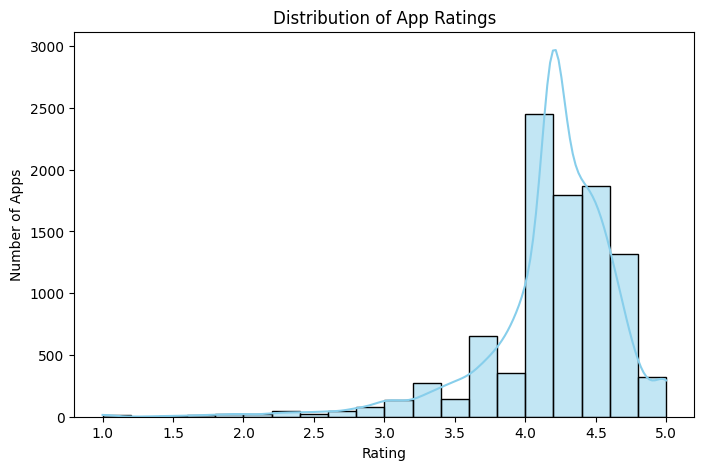

In [116]:
##Visualize Distribution of App Ratings
#Histograms of Ratings:
plt.figure(figsize=(8,5))
sns.histplot(df_apps['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Apps')
plt.show()

"This histogram shows the distribution of app ratings on the Google Play Store, helping us understand how many apps have high or low user ratings."

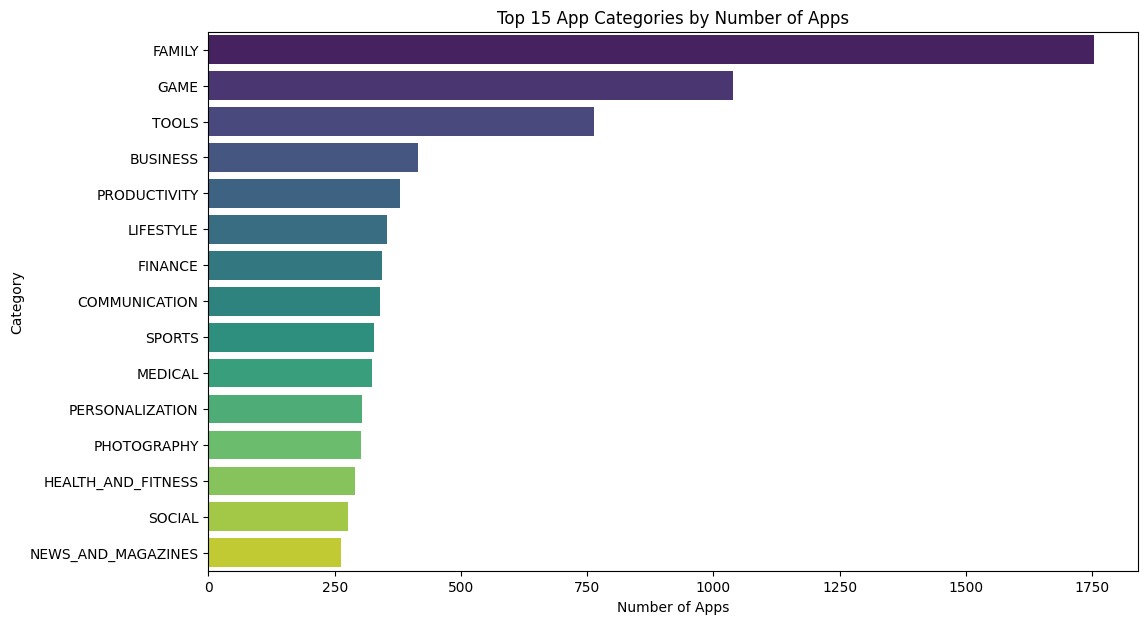

In [117]:
##Top categories by number of apps.
#Bar plot for app categories
plt.figure(figsize=(12,7))
top_categories = df_apps['Category'].value_counts().head(15)
sns.barplot(
    y=top_categories.index, 
    x=top_categories.values, 
    hue=top_categories.index,  # Assign hue for coloring
    palette='viridis', 
    legend=False               # Hide redundant legend
)
plt.title('Top 15 App Categories by Number of Apps')
plt.xlabel('Number of Apps')
plt.ylabel('Category')
plt.show()

Bar plot presenting the categories with the most apps on the Play Store. This highlights which categories are most popular with developers.

Note: Seaborn palette warnings can usually be fixed by setting a hue argument when customizing plot colors. For vertical or horizontal bar plots where the y-axis is categorical, set hue to the category for consistent coloring.

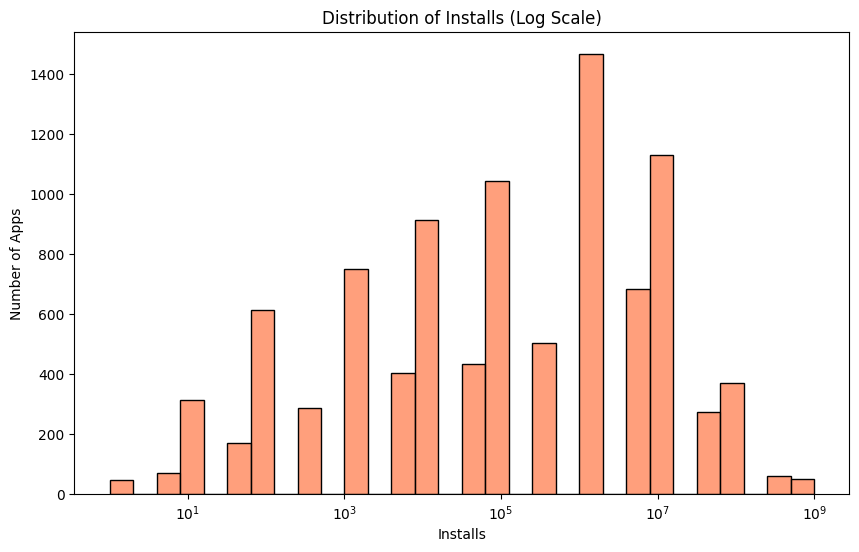

In [118]:
##Distribution of Installs
#Bar Plot for Installs (Log Scale Recommended):
plt.figure(figsize=(10,6))
sns.histplot(df_apps['Installs'], bins=30, color='coral', log_scale=True)
plt.title('Distribution of Installs (Log Scale)')
plt.xlabel('Installs')
plt.ylabel('Number of Apps')
plt.show()


Due to wide variation, installs are plotted on a log scale, showing the frequency of apps at different install levels.

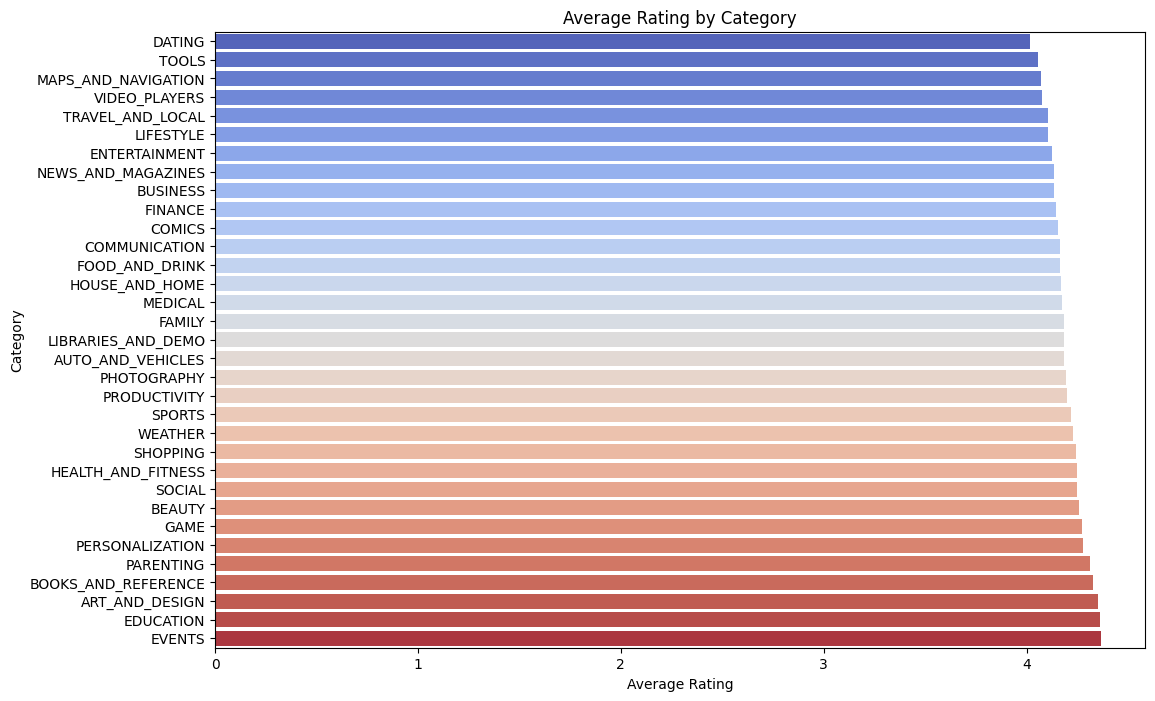

In [119]:
##Average Rating by Category
#Horizontal Bar Plot:
plt.figure(figsize=(12,8))
category_rating = df_apps.groupby('Category')['Rating'].mean().sort_values()
sns.barplot(
    x=category_rating.values, 
    y=category_rating.index, 
    hue=category_rating.index,      # Assign hue for color
    palette='coolwarm', 
    legend=False                    # Hide legend for aesthetic output
)
plt.title('Average Rating by Category')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.show()

Shows which categories tend to have higher-rated apps

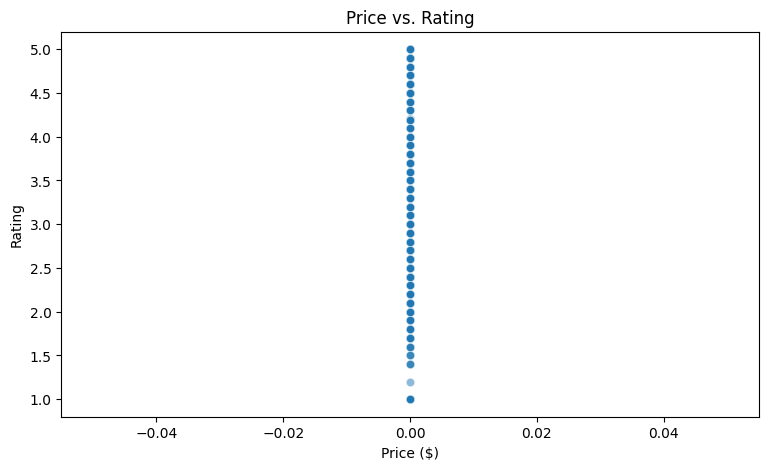

In [120]:
#Price vs Ratings Scatter Plot 
plt.figure(figsize=(9,5))
sns.scatterplot(x='Price', y='Rating', data=df_apps, alpha=0.5)
plt.title('Price vs. Rating')
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.show()

Explores whether there’s a relationship between app price and rating.

# Analysis
### Step 1: Deep Dive by Category
#### 1.1. Calculate Summary Stats for Each Category

In [121]:
# Group by category and calculate mean of relevant columns
category_summary = df_apps.groupby('Category').agg({
    'Rating': 'mean',
    'Installs': 'mean',
    'Reviews': 'mean',
    'Price': 'mean'
}).sort_values('Rating', ascending=False)

# Show top 10 categories by average rating
print(category_summary.head(10))

                       Rating      Installs       Reviews  Price
Category                                                        
EVENTS               4.366351  2.535422e+05  2.555841e+03    0.0
EDUCATION            4.362646  4.232937e+06  1.835782e+05    0.0
ART_AND_DESIGN       4.350492  2.037985e+06  2.806916e+04    0.0
BOOKS_AND_REFERENCE  4.325805  9.534554e+06  1.088130e+05    0.0
PARENTING            4.314369  5.426036e+05  1.637871e+04    0.0
PERSONALIZATION      4.280613  6.787626e+06  2.453810e+05    0.0
GAME                 4.271028  3.036891e+07  1.362182e+06    0.0
BEAUTY               4.260882  5.131519e+05  7.476226e+03    0.0
SOCIAL               4.251144  4.517640e+07  1.926269e+06    0.0
HEALTH_AND_FITNESS   4.247194  4.675424e+06  1.058398e+05    0.0


#### 1.2. Visualize the Results
#### Average Rating by Category (Bar Plot)

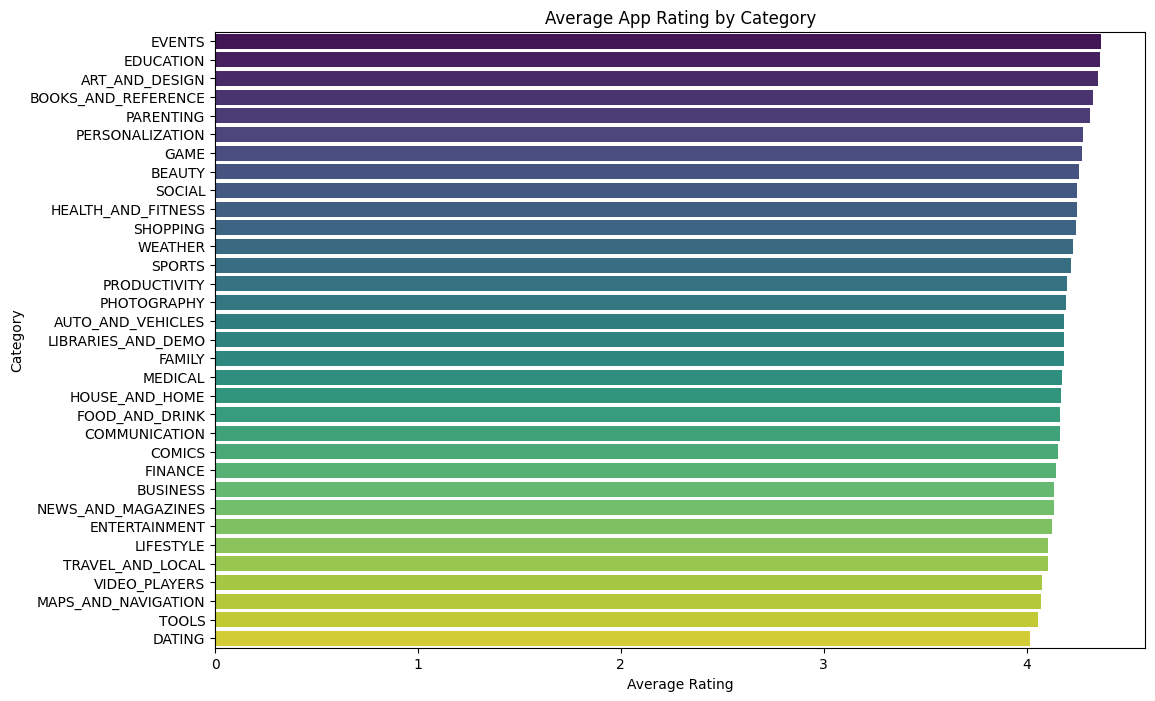

In [122]:
plt.figure(figsize=(12,8))
sns.barplot(
    x=category_summary['Rating'], 
    y=category_summary.index, 
    hue=category_summary.index,      # Assign hue for categorical coloring
    palette='viridis', 
    legend=False                     # Hide redundant legend
)
plt.title('Average App Rating by Category')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.show()

#### Average Installs by Category (Bar Plot)

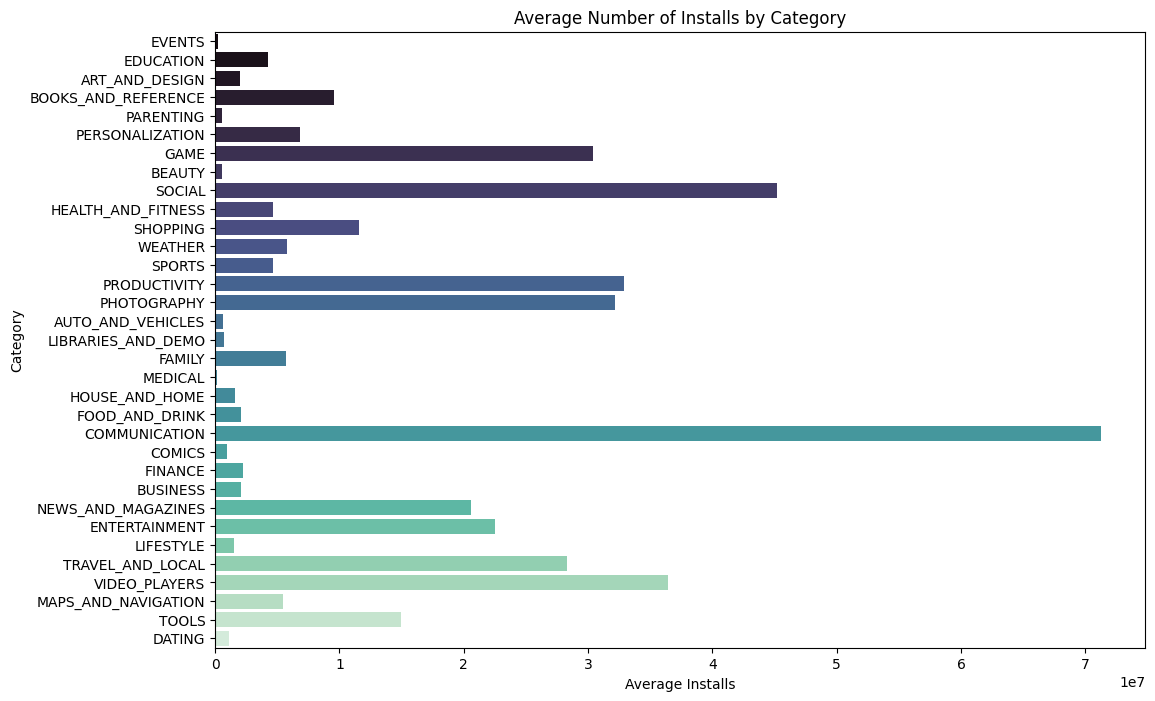

In [123]:
plt.figure(figsize=(12,8))
sns.barplot(
    x=category_summary['Installs'],
    y=category_summary.index,
    hue=category_summary.index,     # assign category as hue for color
    palette='mako',
    legend=False
)
plt.title('Average Number of Installs by Category')
plt.xlabel('Average Installs')
plt.ylabel('Category')
plt.show()

## Deep Dive: What Makes Top-Rated Categories Successful?

We calculate and plot the average rating, installs, reviews, and price for each app category. This helps identify which categories tend to have highly rated apps, which ones get the most downloads, and if there's any category where users are willing to pay more.


#### Average Reviews by Category

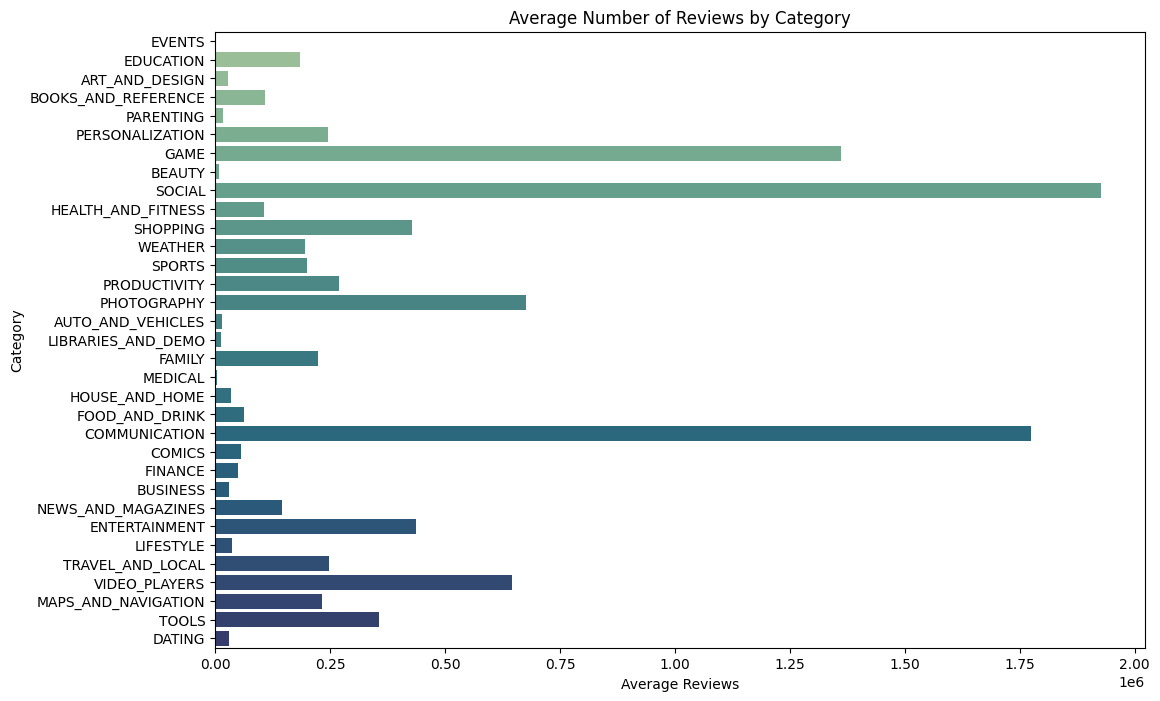

In [124]:
plt.figure(figsize=(12,8))
sns.barplot(
    x=category_summary['Reviews'],
    y=category_summary.index,
    hue=category_summary.index,
    palette='crest',
    legend=False
)
plt.title('Average Number of Reviews by Category')
plt.xlabel('Average Reviews')
plt.ylabel('Category')
plt.show()

#### Average Price by Category



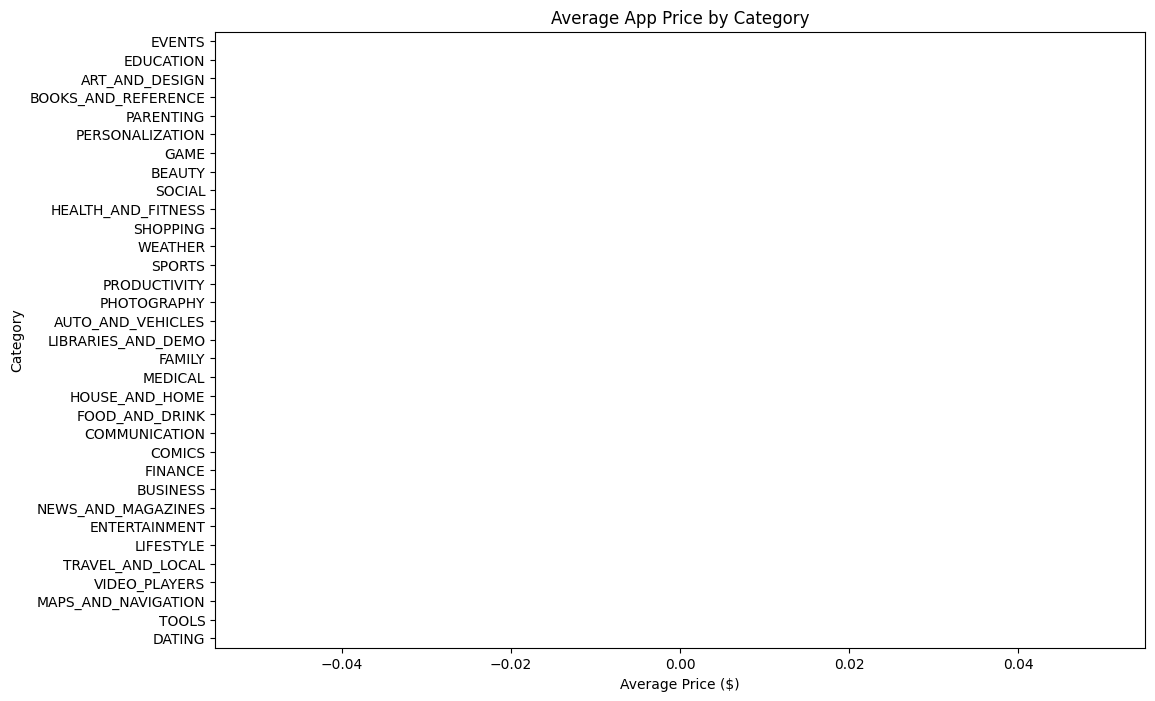

In [125]:
plt.figure(figsize=(12,8))
sns.barplot(
    x=category_summary['Price'],
    y=category_summary.index,
    hue=category_summary.index,
    palette='flare',
    legend=False
)
plt.title('Average App Price by Category')
plt.xlabel('Average Price ($)')
plt.ylabel('Category')
plt.show()

#### Correlation Matrix by Category

How do installs, rating, reviews, and price relate to each other?

            Rating  Installs   Reviews  Price
Rating    1.000000 -0.144143  0.013460    NaN
Installs -0.144143  1.000000  0.868454    NaN
Reviews   0.013460  0.868454  1.000000    NaN
Price          NaN       NaN       NaN    NaN


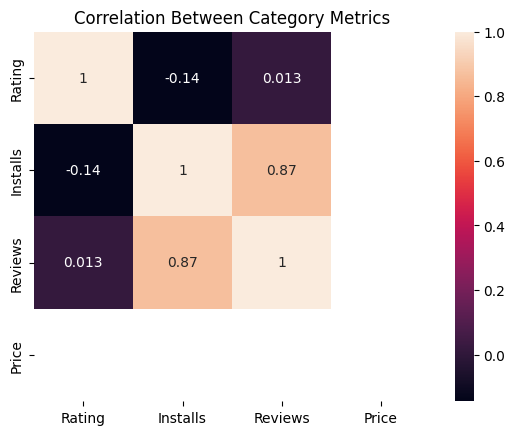

In [126]:
print(category_summary.corr())
sns.heatmap(category_summary.corr(), annot=True)
plt.title('Correlation Between Category Metrics')
plt.show()

#### Top/Bottom Analysis

Show top 5 and bottom 5 for each metric.

In [127]:
print(category_summary.sort_values('Reviews', ascending=False).head(5))   # Top by reviews
print(category_summary.sort_values('Reviews').head(5))                    # Bottom by reviews

                 Rating      Installs       Reviews  Price
Category                                                  
SOCIAL         4.251144  4.517640e+07  1.926269e+06    0.0
COMMUNICATION  4.163836  7.124164e+07  1.773420e+06    0.0
GAME           4.271028  3.036891e+07  1.362182e+06    0.0
PHOTOGRAPHY    4.193069  3.218301e+07  6.760459e+05    0.0
VIDEO_PLAYERS  4.074269  3.638557e+07  6.454200e+05    0.0
                      Rating       Installs       Reviews  Price
Category                                                        
EVENTS              4.366351  253542.222222   2555.841270    0.0
MEDICAL             4.174158  128220.197531   4240.209877    0.0
BEAUTY              4.260882  513151.886792   7476.226415    0.0
LIBRARIES_AND_DEMO  4.182812  746937.469880  12252.638554    0.0
AUTO_AND_VEHICLES   4.185773  647317.817073  14140.280488    0.0


Advanced: Pairplot (Visualizes all variable relationships at once)

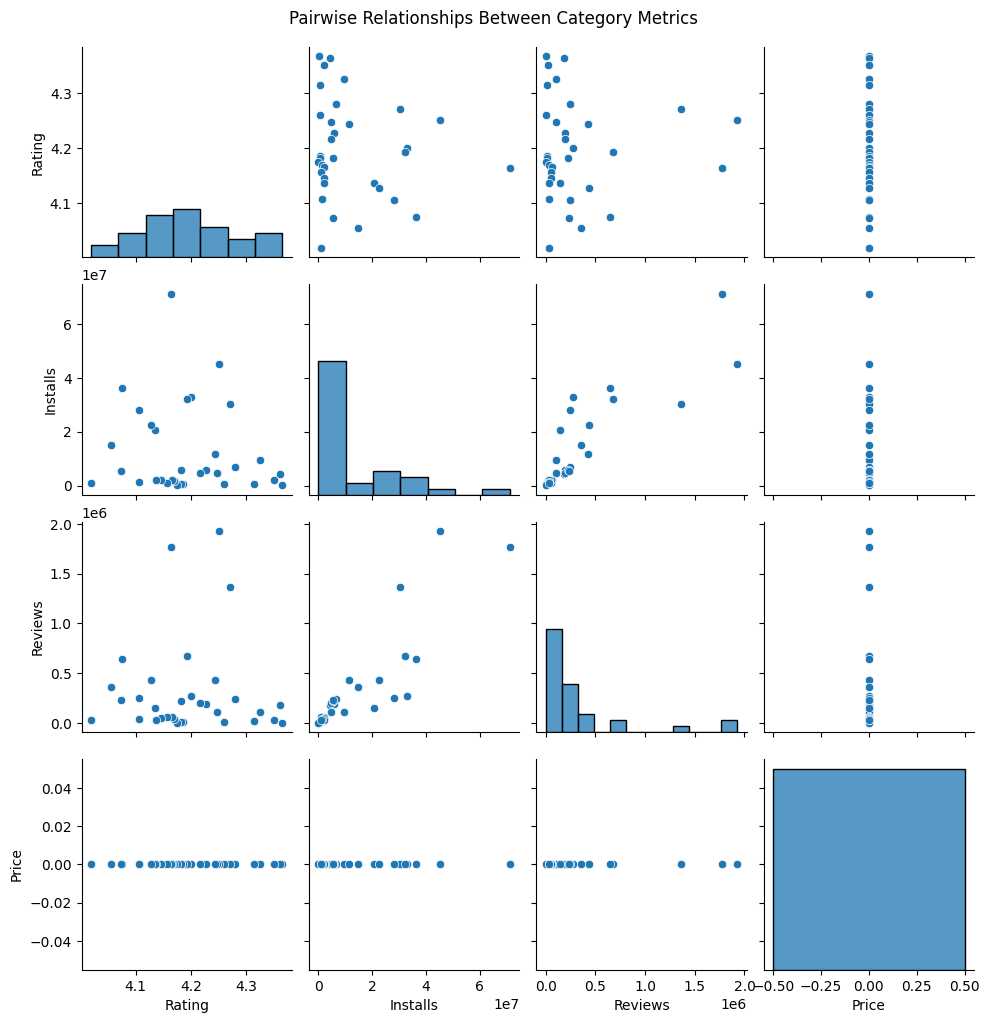

In [128]:
sns.pairplot(category_summary)
plt.suptitle("Pairwise Relationships Between Category Metrics", y=1.02)
plt.show()

### Step 2: Investigate Low-Rated Apps
#### A. Filter Low-Rated Apps (e.g., Rating < 3.0)

In [129]:
# Filter apps with ratings less than 3
low_rated = df_apps[df_apps['Rating'] < 3.0]

# Check number of low-rated apps
print("Number of low-rated apps:", len(low_rated))

# Show distribution across categories
print(low_rated['Category'].value_counts())

# Preview top few to spot patterns
print(low_rated[['App','Category','Rating','Installs','Reviews','Price']].head(10))

Number of low-rated apps: 258
Category
TOOLS                  39
FAMILY                 38
LIFESTYLE              22
HEALTH_AND_FITNESS     20
FINANCE                19
MEDICAL                16
BUSINESS               16
PRODUCTIVITY           11
NEWS_AND_MAGAZINES     10
PHOTOGRAPHY            10
GAME                    8
DATING                  8
TRAVEL_AND_LOCAL        6
VIDEO_PLAYERS           6
MAPS_AND_NAVIGATION     5
SPORTS                  5
COMMUNICATION           4
FOOD_AND_DRINK          3
SOCIAL                  3
SHOPPING                2
AUTO_AND_VEHICLES       2
COMICS                  1
EVENTS                  1
BOOKS_AND_REFERENCE     1
HOUSE_AND_HOME          1
PERSONALIZATION         1
Name: count, dtype: int64
                                                 App Category  Rating  \
518                    Just She - Top Lesbian Dating   DATING     1.9   
520   EliteSingles – Dating for Single Professionals   DATING     2.5   
527                           Sugar Dadd

#### B. Visualize Low-Rated Apps

Bar plot: Which Categories have the Most Low-Rated Apps?

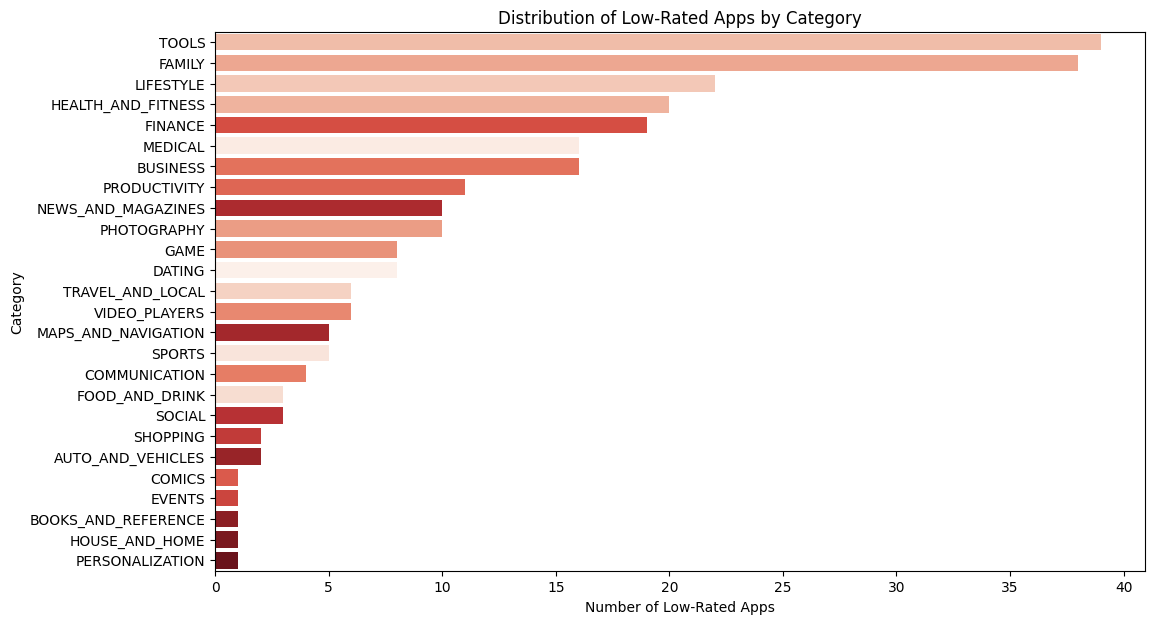

In [130]:
plt.figure(figsize=(12,7))
sns.countplot(
    y=low_rated['Category'],
    hue=low_rated['Category'],
    order=low_rated['Category'].value_counts().index,
    palette='Reds',
    legend=False
)
plt.title('Distribution of Low-Rated Apps by Category')
plt.xlabel('Number of Low-Rated Apps')
plt.ylabel('Category')
plt.show()

Histogram: Installs Distribution of Low-Rated Apps

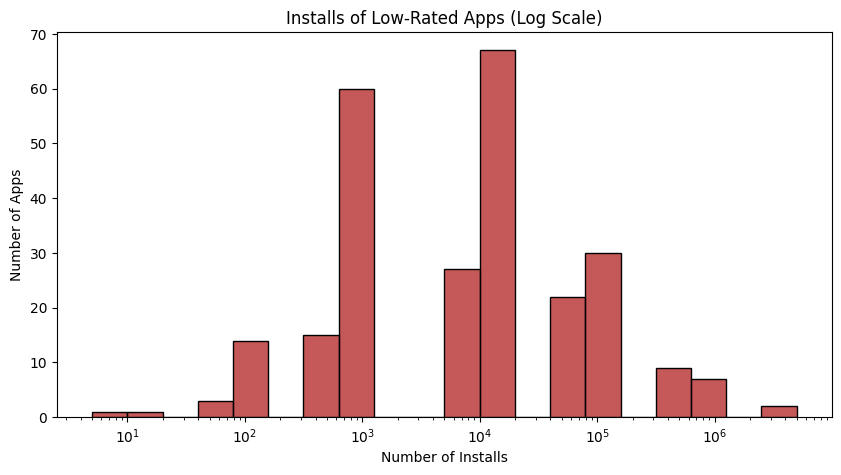

In [131]:
plt.figure(figsize=(10,5))
sns.histplot(low_rated['Installs'], bins=20, color='firebrick', log_scale=True)
plt.title('Installs of Low-Rated Apps (Log Scale)')
plt.xlabel('Number of Installs')
plt.ylabel('Number of Apps')
plt.show()

### Investigating Low-Rated Apps

We focus on apps with ratings below 3.0 to identify persistent issues in Play Store offerings. By examining which categories these apps belong to, and their download volumes, we can highlight segments of the app ecosystem where users are dissatisfied. This analysis can guide developers toward categories or features needing the most improvement.

#### Interpretation Prompts:
- Which categories most frequently have low-rated apps?
- Are low-rated apps widely installed, or do they attract few users?
- Is there a pattern (e.g., niche app types, paid/free, genre) among low-rated apps?


# Analyzing what features or problems are most common among low-rated apps. 
#### A. Feature Distribution among Low-Rated Apps
1. Price

In [132]:
print(low_rated['Price'].describe())  # Mean, median, high/low for price

count    258.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Price, dtype: float64


2. App Type (Free/Paid)

Type
Free    258
Name: count, dtype: int64


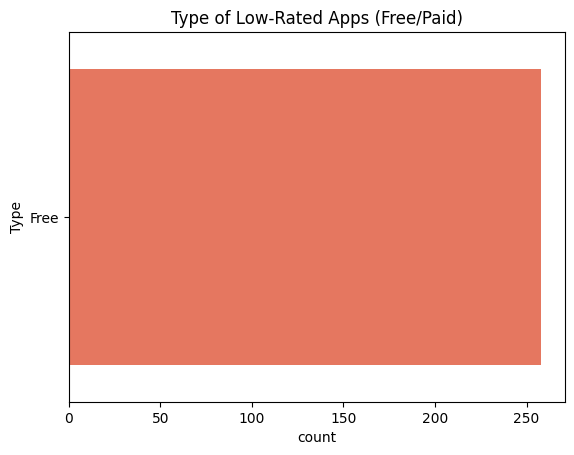

In [133]:
print(low_rated['Type'].value_counts())
sns.countplot(
    y=low_rated['Type'],
    hue=low_rated['Type'],
    palette="Reds",
    legend=False
)
plt.title("Type of Low-Rated Apps (Free/Paid)")
plt.show()

3. Content Rating

Content Rating
Everyone        235
Mature 17+       12
Teen              7
Everyone 10+      4
Name: count, dtype: int64


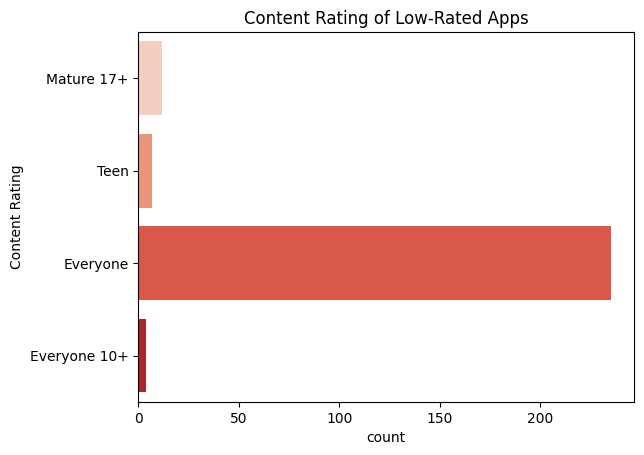

In [134]:
print(low_rated['Content Rating'].value_counts())
sns.countplot(
    y=low_rated['Content Rating'],
    hue=low_rated['Content Rating'],
    palette="Reds",
    legend=False
)
plt.title("Content Rating of Low-Rated Apps")
plt.show()

4. App Size

In [135]:
print(low_rated['Size'].describe())

count     258
unique    117
top       18M
freq        7
Name: Size, dtype: object


#### B. User Reviews Analysis
1. Subset User Reviews for Low-Rated Apps

In [136]:
low_rated_reviews = df_reviews_clean[df_reviews_clean['App'].isin(low_rated['App'])]

2. Review Sentiment

count    96.000000
mean     -0.099362
std       0.326284
min      -1.000000
25%      -0.287879
50%       0.000000
75%       0.100000
max       0.614583
Name: Sentiment_Polarity, dtype: float64
Sentiment
Negative    40
Neutral     29
Positive    27
Name: count, dtype: int64


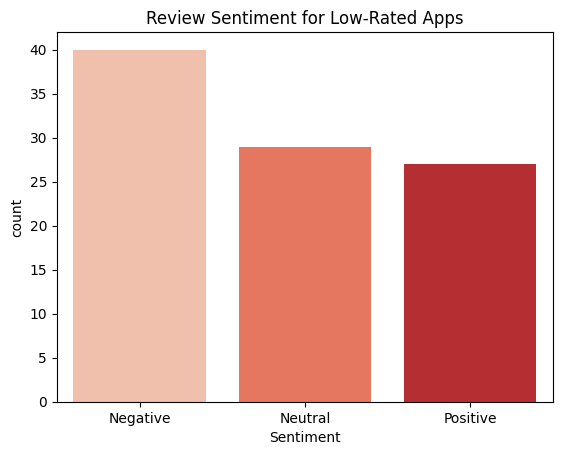

In [137]:
print(low_rated_reviews['Sentiment_Polarity'].describe())
print(low_rated_reviews['Sentiment'].value_counts())
sns.countplot(
    x=low_rated_reviews['Sentiment'],
    hue=low_rated_reviews['Sentiment'],
    palette="Reds",
    legend=False
)
plt.title("Review Sentiment for Low-Rated Apps")
plt.show()

3. Most Frequent Problems (Keywords)

In [138]:
# Combine all review texts
text = " ".join(low_rated_reviews['Translated_Review'].dropna().values)
# Extract words
words = re.findall(r'\w+', text.lower())
common_words = Counter(words).most_common(20)  # Top 20 frequent words
print(common_words)


[('i', 46), ('t', 35), ('can', 28), ('information', 19), ('the', 18), ('login', 17), ('even', 16), ('get', 15), ('log', 15), ('claims', 14), ('work', 13), ('phone', 12), ('it', 12), ('screen', 11), ('find', 11), ('s', 11), ('this', 11), ('card', 10), ('not', 10), ('app', 10)]


C. Word Cloud for Visualizing Frequent Complaint Words

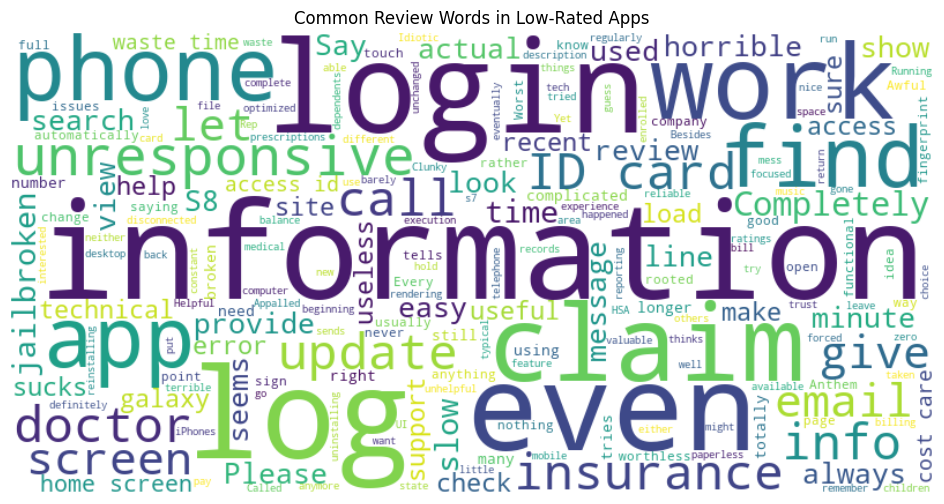

In [139]:
wc = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Common Review Words in Low-Rated Apps')
plt.show()

#### Combined Analysis: Features & User Feedback for Low-Rated Apps

We analyzed the characteristics (price, type, content rating, size) and user review sentiment of low-rated apps.
- Most low-rated apps are free and target broad audiences ("Everyone").
- User reviews are overwhelmingly negative, with frequent complaints about ads, crashes, usability, and bugs as revealed by keyword analysis and word cloud.
- The mean price of low-rated apps is close to zero, confirming that quality problems frustrate users regardless of cost.


In [140]:
df_reviews_clean = df_reviews.dropna(subset=['Translated_Review'])

#### Install Success Factors Analysis
##### A. Correlation Analysis
First, let’s see which numeric features are most correlated with install counts.

          Installs    Rating   Reviews  Price
Installs  1.000000  0.054411  0.634292    NaN
Rating    0.054411  1.000000  0.072640    NaN
Reviews   0.634292  0.072640  1.000000    NaN
Price          NaN       NaN       NaN    NaN


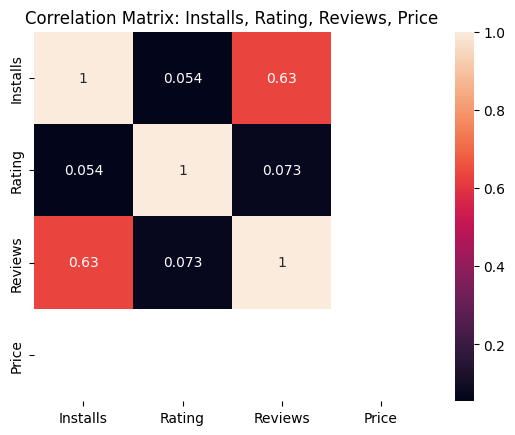

In [141]:
corr = df_apps[['Installs', 'Rating', 'Reviews', 'Price']].corr()
print(corr)
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix: Installs, Rating, Reviews, Price')
plt.show()

###### Interpret: Strong correlation means a feature closely links to high installs.

#### B. Visualize Relationships
##### 1. Installs vs. Reviews

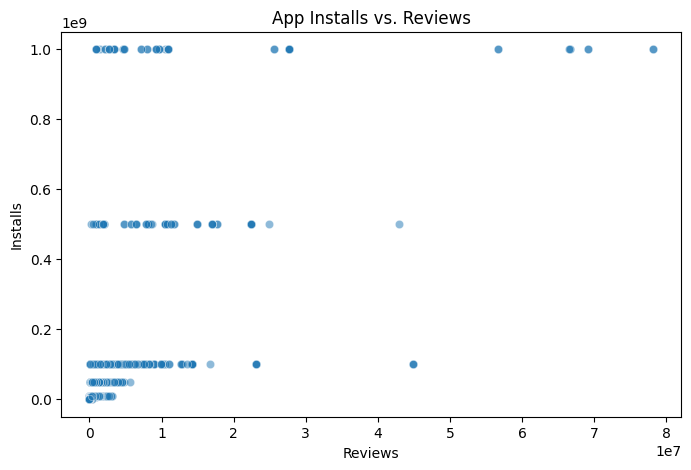

In [142]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Reviews', y='Installs', data=df_apps, alpha=0.5)
plt.title('App Installs vs. Reviews')
plt.xlabel('Reviews')
plt.ylabel('Installs')
plt.show()

##### 2. Installs vs. Rating

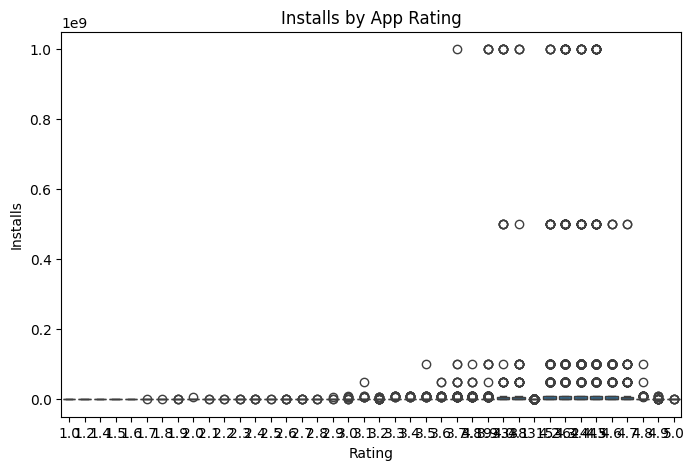

In [143]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Rating', y='Installs', data=df_apps)
plt.title('Installs by App Rating')
plt.xlabel('Rating')
plt.ylabel('Installs')
plt.show()

#### C. Advanced: Regression Model 
If we want to predict installs, we can fit a simple linear regression

In [144]:
X = df_apps[['Rating', 'Reviews', 'Price']]
y = df_apps['Installs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Model score (R2):", lr.score(X_test, y_test))

Model score (R2): 0.39799494914686806


Correlation analysis reveals what features most strongly drive app installs—typically high review counts and, to a much lesser extent, ratings and price. Apps with more reviews often have more installs, indicating popularity and active user engagement. Regression modeling can further clarify which attributes most reliably forecast future installs.

##### Sentiment Analysis of User Reviews (Full Dataset)
1. Calculate Average Sentiment Per App

In [145]:
sentiment_summary = df_reviews_clean.groupby('App')['Sentiment_Polarity'].mean()
df_apps_sentiment = df_apps.join(sentiment_summary, on='App')

2. Visualize Relationship Between Sentiment and App Rating

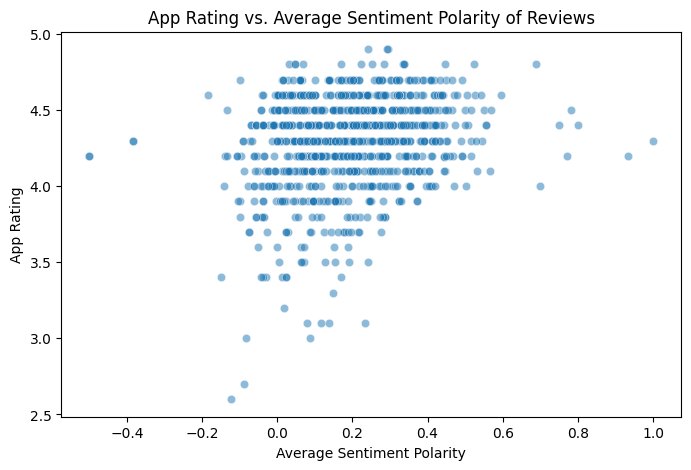

In [146]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Sentiment_Polarity', y='Rating', data=df_apps_sentiment, alpha=0.5)
plt.title('App Rating vs. Average Sentiment Polarity of Reviews')
plt.xlabel('Average Sentiment Polarity')
plt.ylabel('App Rating')
plt.show()

3. Visualize Relationship Between Sentiment and Installs

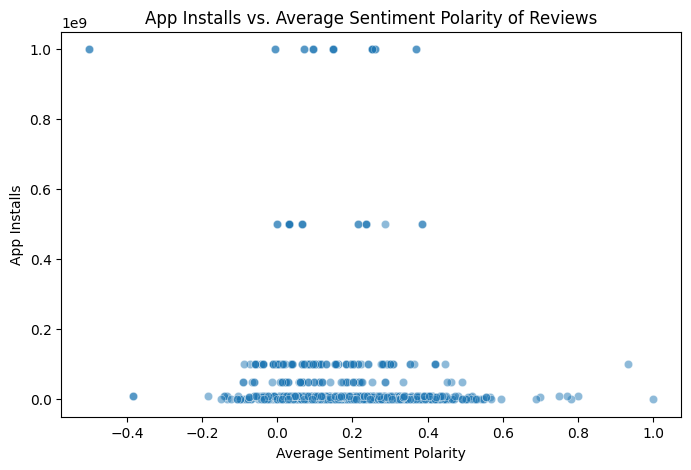

In [147]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Sentiment_Polarity', y='Installs', data=df_apps_sentiment, alpha=0.5)
plt.title('App Installs vs. Average Sentiment Polarity of Reviews')
plt.xlabel('Average Sentiment Polarity')
plt.ylabel('App Installs')
plt.show()

4. Calculate and Show Correlations

In [148]:
print(df_apps_sentiment[['Rating', 'Installs', 'Sentiment_Polarity']].corr())

                      Rating  Installs  Sentiment_Polarity
Rating              1.000000  0.054411            0.207455
Installs            0.054411  1.000000           -0.131445
Sentiment_Polarity  0.207455 -0.131445            1.000000


This analysis links user review sentiment directly with app performance outcomes. High sentiment polarity (more positive reviews) may be associated with higher ratings and more installs. However, clusters of apps with neutral or negative sentiment may reveal brands or categories where user experience needs urgent improvement.

#### Time Series Analysis: Update Activity & Impact on App Ratings
A. Convert 'Last Updated' to Datetime

In [149]:
df_apps['Last Updated'] = pd.to_datetime(df_apps['Last Updated'], errors='coerce')

B. Feature Engineering: 

B.1. Extract Year of Last Update

In [150]:
df_apps['Last Updated Year'] = df_apps['Last Updated'].dt.year

B.2. Analyze How Rating Varies by Last Update Year

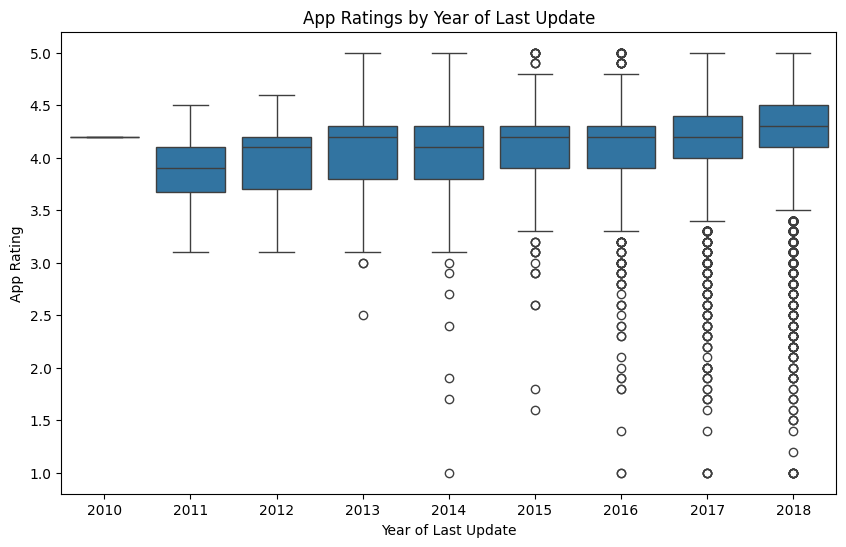

In [151]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Last Updated Year', y='Rating', data=df_apps)
plt.title('App Ratings by Year of Last Update')
plt.xlabel('Year of Last Update')
plt.ylabel('App Rating')
plt.show()

C. Scatterplot: Last Update Recency vs App Rating

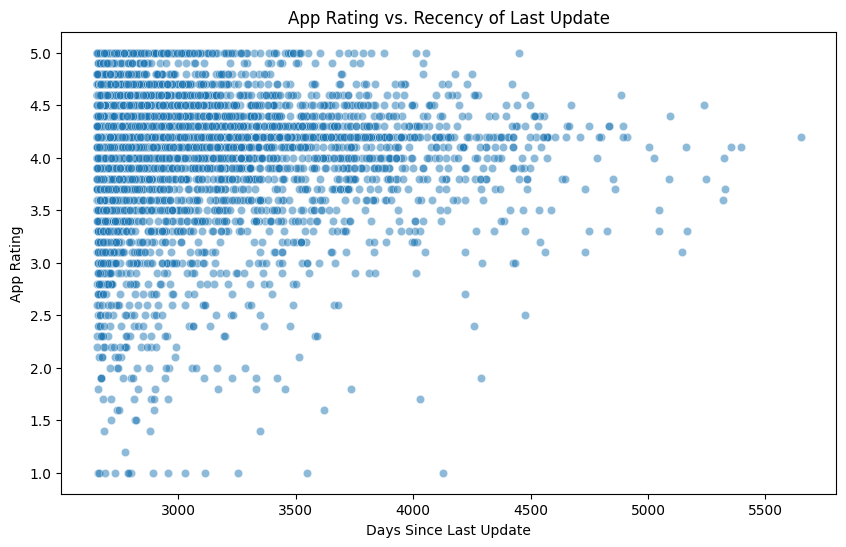

In [152]:
df_apps['Days Since Last Update'] = (datetime.datetime.now() - df_apps['Last Updated']).dt.days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Days Since Last Update', y='Rating', data=df_apps, alpha=0.5)
plt.title('App Rating vs. Recency of Last Update')
plt.xlabel('Days Since Last Update')
plt.ylabel('App Rating')
plt.show()

D. Correlation: Days Since Update & Rating

In [153]:
print(df_apps[['Days Since Last Update','Rating']].corr())

                        Days Since Last Update    Rating
Days Since Last Update                1.000000 -0.142137
Rating                               -0.142137  1.000000


This analysis investigates whether frequently-updated apps (or recently-updated apps) achieve higher user ratings. Visualizing update recency against ratings provides insight into user preferences for up-to-date and well-maintained apps.

### Modeling
1.  Feature Engineering for App Rating Prediction (Regression)

In [154]:
# Ensure Sentiment_Polarity exists in df_apps
sentiment_summary = df_reviews_clean.groupby('App')['Sentiment_Polarity'].mean()
df_apps = df_apps.join(sentiment_summary, on='App')

In [155]:
# ------- Features for Regression Model (Predicting App Ratings) -------
features_reg = [
    'Reviews', 'Installs', 'Price', 'Sentiment_Polarity', 'Days Since Last Update'
]

categorical_cols = ['Category', 'Type', 'Content Rating']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df_apps[categorical_cols])
encoded_cat_df = pd.DataFrame(
    encoded_cats, 
    columns=encoder.get_feature_names_out(categorical_cols), 
    index=df_apps.index
)

# Combine all features
df_model_reg = pd.concat([df_apps[features_reg], encoded_cat_df], axis=1)

# Scale the features
scaler = StandardScaler()
X_reg = scaler.fit_transform(df_model_reg)
y_reg = df_apps['Rating']  # Target variable for regression


2. Feature Engineering for Sentiment Prediction (Classification)

In [156]:
# Text features
reviews = df_reviews_clean['Translated_Review'].fillna('')
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(reviews)

# Ensure unique App names (drop duplicates—keep the first row for each app)
df_apps = df_apps.drop_duplicates(subset=['App'])

# Now you can safely set App as index for mapping
app_category_map = df_apps.set_index('App')['Category']
app_features_cls = df_reviews_clean.copy()
app_features_cls['Category'] = app_features_cls['App'].map(app_category_map).fillna("Unknown")

# Now encode just review-by-review categories
cat_only_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_cat_cls = cat_only_encoder.fit_transform(app_features_cls['Category'].values.reshape(-1,1))  # This will match rows in df_reviews_clean

# Combine text and category features for classification model
X_cls = np.concatenate([X_text.toarray(), encoded_cat_cls], axis=1)
y_cls = df_reviews_clean['Sentiment']

3. Regression Model for App Rating

In [157]:
# Before splitting data:
print(np.isnan(X_reg).sum())  # Total number of NaN values
# Get indices of non-NaN rows
mask = ~np.isnan(X_reg).any(axis=1)
X_reg_clean = X_reg[mask]
y_reg_clean = y_reg[mask]

# Then split:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_clean, y_reg_clean, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg)

print("Regression Model R2 Score:", reg_model.score(X_test_reg, y_test_reg))

8517
Regression Model R2 Score: 0.18335642121628626


4. Classification Model for Sentiment Prediction

In [158]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf.predict(X_test_cls)

from sklearn.metrics import accuracy_score, classification_report

print("Sentiment Classification Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))


Sentiment Classification Accuracy: 0.8939353459791611
              precision    recall  f1-score   support

    Negative       0.90      0.77      0.83      1653
     Neutral       0.79      0.86      0.82      1049
    Positive       0.92      0.94      0.93      4784

    accuracy                           0.89      7486
   macro avg       0.87      0.86      0.86      7486
weighted avg       0.89      0.89      0.89      7486



1. Handle Missing Values (Mean Imputation)

In [159]:
# Impute missing values in X_reg using column means
imputer = SimpleImputer(strategy='mean')
X_reg_imputed = imputer.fit_transform(X_reg)

2. Train/Test Split and Model Training

In [160]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_imputed, y_reg, test_size=0.2, random_state=42
)

reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)
joblib.dump(reg_model, 'reg_model.joblib')
y_pred_reg = reg_model.predict(X_test_reg)

print("Regression Model R2 Score:", reg_model.score(X_test_reg, y_test_reg))


Regression Model R2 Score: 0.03084899982537137


In [161]:
joblib.dump(clf, 'clf.joblib',compress=3)
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(imputer, 'imputer.joblib')
joblib.dump(tfidf, 'tfidf.joblib')
joblib.dump(cat_only_encoder, 'cat_only_encoder.joblib')
joblib.dump(X_test_reg, 'X_test_reg.joblib')
joblib.dump(y_test_reg, 'y_test_reg.joblib')
joblib.dump(features_reg, 'features_reg.joblib')
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

3. Model Evaluation  (Root Mean Squared Error):

In [162]:
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("Regression Model RMSE:", rmse)

Regression Model RMSE: 0.49191901580934005


#### Step: Model Explainability (Feature Importance/SHAP)
1.  Linear Regression Model: Feature Importance

                           Feature   Coefficient
4           Days Since Last Update -7.422017e-02
3               Sentiment_Polarity  6.962053e-02
34                  Category_TOOLS -3.777381e-02
19                   Category_GAME  2.913470e-02
0                          Reviews  2.287718e-02
28        Category_PERSONALIZATION  2.117160e-02
8     Category_BOOKS_AND_REFERENCE  2.106050e-02
13              Category_EDUCATION  1.836503e-02
12                 Category_DATING -1.618432e-02
35       Category_TRAVEL_AND_LOCAL -1.525224e-02
24    Category_MAPS_AND_NAVIGATION -1.438624e-02
36          Category_VIDEO_PLAYERS -1.205139e-02
23              Category_LIFESTYLE -1.183813e-02
15                 Category_EVENTS  1.179760e-02
27              Category_PARENTING  1.175946e-02
5          Category_ART_AND_DESIGN  1.166598e-02
14          Category_ENTERTAINMENT -1.115630e-02
17                Category_FINANCE -1.108958e-02
32                 Category_SOCIAL  1.104316e-02
26     Category_NEWS

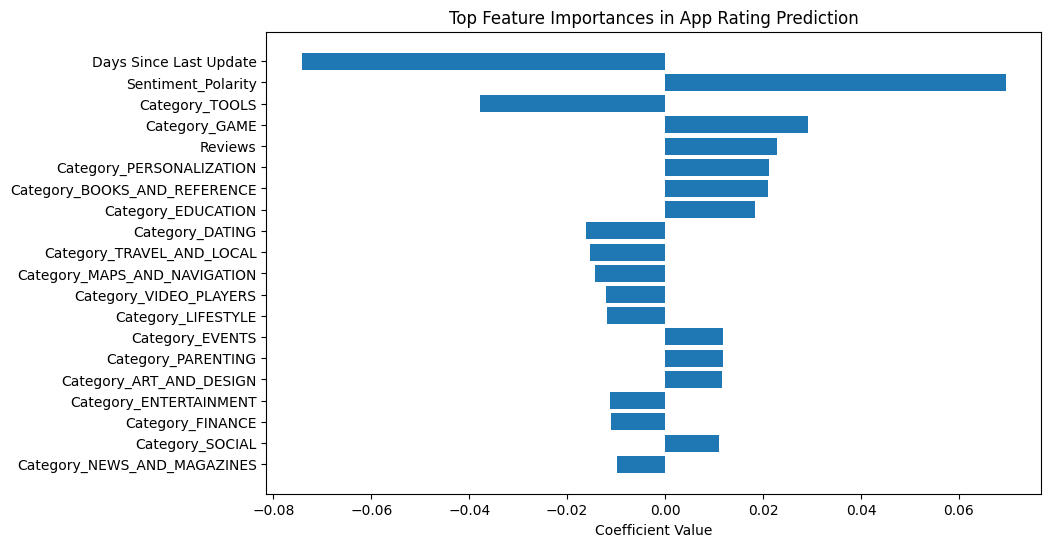

In [163]:
# Get feature importances

feature_names = df_model_reg.columns
coefficients = reg_model.coef_

# Create a dataframe for easy interpretation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)

print(importance_df)

# Plot top coefficients
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:20], importance_df['Coefficient'][:20])
plt.xlabel('Coefficient Value')
plt.title('Top Feature Importances in App Rating Prediction')
plt.gca().invert_yaxis()
plt.show()


2. SHAP for Advanced Explainability

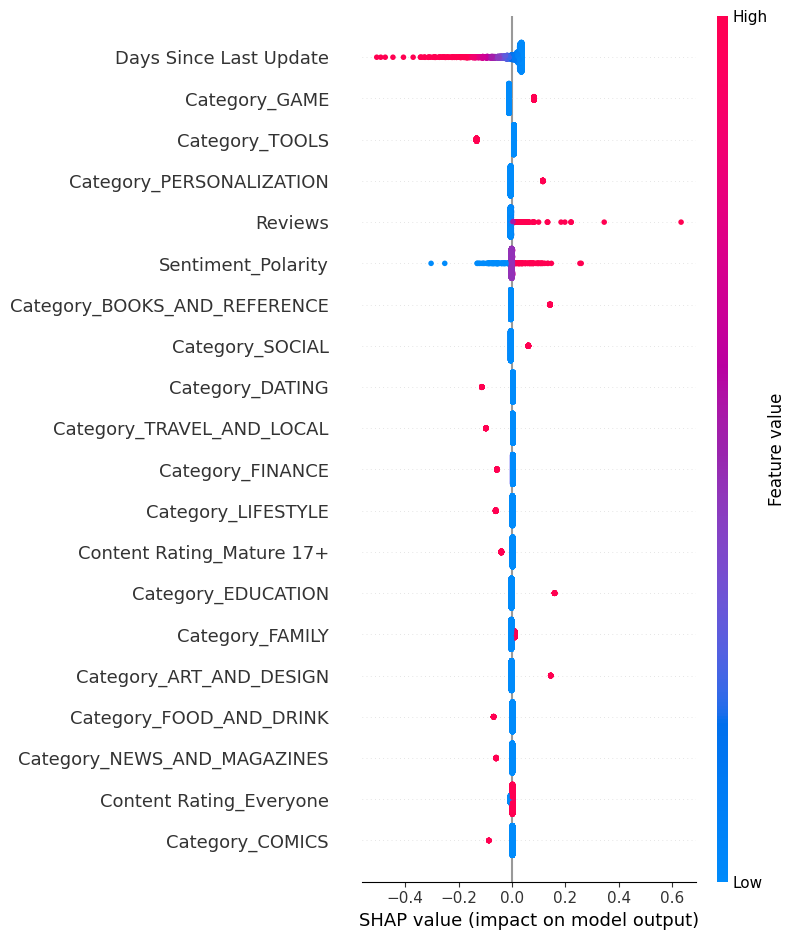

In [164]:
# Create explainer
explainer = shap.LinearExplainer(reg_model, X_train_reg, feature_names=feature_names)
shap_values = explainer.shap_values(X_test_reg)

# SHAP summary plot: Which features matter most overall
shap.summary_plot(shap_values, X_test_reg, feature_names=feature_names, show=True)


3. Random Forest (for Sentiment Model): Feature Importances

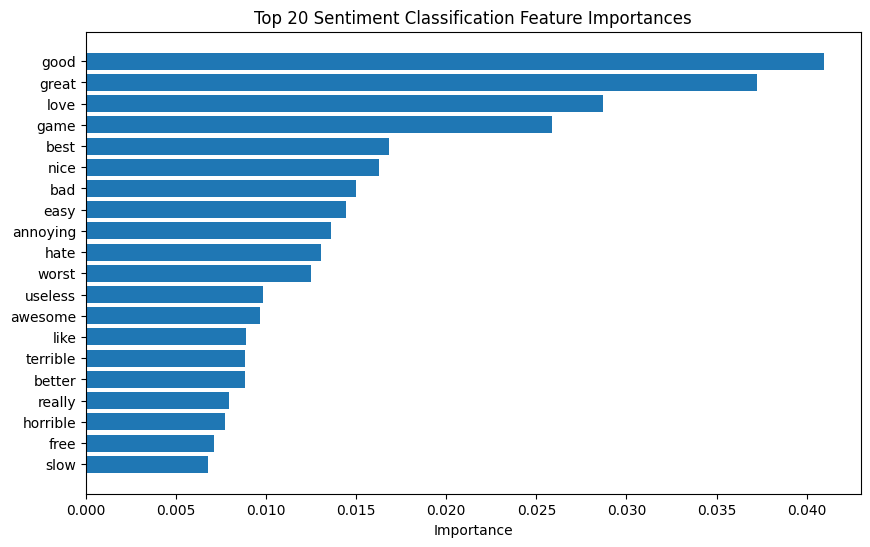

In [165]:
# For Random Forest Sentiment Model
importances = clf.feature_importances_
feature_names_cls = list(tfidf.get_feature_names_out()) + list(cat_only_encoder.get_feature_names_out(['Category']))

# Top features
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10,6))
plt.barh([feature_names_cls[i] for i in indices], importances[indices])
plt.xlabel('Importance')
plt.title('Top 20 Sentiment Classification Feature Importances')
plt.gca().invert_yaxis()
plt.show()